In [1]:
import torch
import torchvision 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import re
from tqdm.notebook import trange, tqdm
from sklearn import tree
import pandas as pd

In [2]:
data = pd.ExcelFile('data.xlsx')
data= data.parse('Supplementary Data 1')
data = data['Transcript']

In [ ]:
minlen = 5000
for i in trange(len(data)):
    if(len(data[i]) < minlen):
        minlen = len(data[i])
print(minlen)

In [27]:
strings = np.zeros((30,len(data)))
for i1 in trange(30):
    i = i1*10 + 10
    for j in trange(len(data)):
        reg = data[j][len(data[j])- i - 1:len(data[j])]
        for k in range(len(data)):
            strings[i1][j] += len(re.findall(reg,data[k][0:len(data[k]) - 500]))
    with open('strings{}'.format(i + 10), 'wb') as f:
        pickle.dump(strings, f)
strings_expand = np.zeros((20,len(data)))
for i1 in trange(20):
    i = i1*10 + 300
    for j in trange(len(data)):
        reg = data[j][len(data[j])- i - 1:len(data[j])]
        for k in range(len(data)):
            strings_expand[i1][j] += len(re.findall(reg,data[k][0:len(data[k]) - 500]))
    with open('strings_expand{}'.format(i + 300), 'wb') as f:
        pickle.dump(strings_expand, f)
reg = data[1119][len(data[1119])- 300 - 1:len(data[1119])]
strings300_where = []
for k in range(len(data)):
    if(len(re.findall(reg,data[k][0:len(data[k]) - 300])) > 0):
        strings300_where.append(k)
with open('strings300_where', 'wb') as f:
        pickle.dump(strings300_where, f)  

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

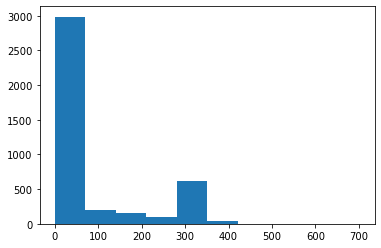

In [35]:
plt.hist(strings[29], bins= 10)
plt.show()

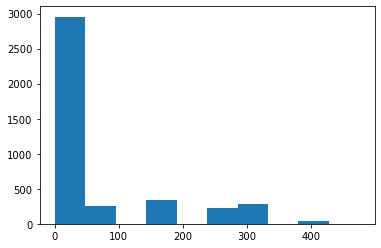

In [36]:
plt.hist(strings_expand[19], bins= 10)
plt.show()

In [11]:
X = []
Y = []
X_test = []
Y_test = []

In [79]:
def transform(x):
    new_x = torch.zeros(len(x))
    for i in range(len(x)):
        if x[i] == 'A':
            new_x[i] = 1
        if x[i] == 'C':
            new_x[i] = 2
        if x[i] == 'G':
            new_x[i] = -1
        if x[i] == 'T':
            new_x[i] = -2
    return(new_x)

In [48]:
X = []
Y = []
for i in trange(len(data)):
    for j in range(100):
        k = np.random.randint(len(data[i]) - 600)
        X.append(data[i][k+j:k+j+300])
        Y.append(0)
        k = np.random.randint(len(data[i]) - 600)
        X.append(data[i][k+j:k+j+300])
        Y.append(0)
        k = np.random.randint(len(data[i]) - 600)
        X.append(data[i][k+j:k+j+300])
        Y.append(0)
        X.append(data[i][len(data[i])-j -300 :len(data[i])-j])
        Y.append(1)
new_x_test = []
for i in trange(len(X)):
    new_x_test.append(transform(X[i]))

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/1646400 [00:00<?, ?it/s]

In [ ]:
new_x = []
for i in trange(len(X)):
    new_x.append(transform(X[i]))
new_x_test = []
for i in trange(len(X_test)):
    new_x_test.append(transform(X_test[i]))

In [7]:
d = list(zip(new_x,Y))
random.shuffle(d)
with open('data', 'wb') as f:
    pickle.dump(d, f)
d = list(zip(new_x_test,Y))
random.shuffle(d)
with open('data_test', 'wb') as f:
    pickle.dump(d, f)    

In [2]:

with open('data', 'rb') as f:
    data = pickle.load(f)
with open('data_test', 'rb') as f:
    data_test = pickle.load(f)

In [9]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc0 = nn.Linear(300,100)
        self.t1 = nn.Tanh()
        self.fc1 = nn.Linear(100,20)
        self.t2 = nn.Tanh() 
        self.fc2 = nn.Linear(20,2) 
    def forward(self, x):
        x = self.fc0(x)
        x = self.t1(x)
        x = self.fc1(x)
        x = self.t2(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim = 0)

In [10]:
batch_size = 8
train_loader = torch.utils.data.DataLoader(
  data[0:len(data)*2/3],batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
  data[len(data)*2/3:len(data)],batch_size=batch_size, shuffle=True)


In [11]:
net = SimpleNet() 
optimiser = torch.optim.Adam(net.parameters())
def train(net,optimiser,n_epochs):
    ans = []
    for epoch in trange(n_epochs):
        net.train()
        for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
            optimiser.zero_grad()
            output = net(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimiser.step()
        net.eval()
        correct = 0
        test_loss = 0
        with torch.no_grad():
            for batch_idx, (data, target) in tqdm(enumerate(test_loader)):
                output = net(data)
                test_loss += F.nll_loss(output, target).item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()
        print('Epoch {}, Accuracy {}'.format(epoch, 100. * correct / len(test_loader.dataset)))
        ans.append(100. * correct / len(test_loader.dataset))
    return net,ans

In [12]:
net = SimpleNet() 
optimiser = torch.optim.Adam(net.parameters())
net,ans = train(net,optimiser,15)

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 0, Accuracy 88


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 1, Accuracy 90


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 2, Accuracy 91


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 3, Accuracy 91


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 4, Accuracy 92


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 5, Accuracy 92


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 6, Accuracy 92


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 7, Accuracy 92


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 8, Accuracy 92


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 9, Accuracy 92


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 10, Accuracy 92


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 11, Accuracy 92


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 12, Accuracy 92


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 13, Accuracy 93


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch 14, Accuracy 93


In [24]:
test_loader = torch.utils.data.DataLoader(
  data_test,batch_size=batch_size, shuffle=True)

def eval(net,test_loader):
    net.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
            for batch_idx, (data, target) in tqdm(enumerate(test_loader)):
                output = net(data)
                test_loss += F.nll_loss(output, target).item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()
    print('Eval, Accuracy {}'.format( 100. * correct / len(test_loader.dataset)))
    return net,ans

In [25]:
net,ans = eval(net,test_loader)

0it [00:00, ?it/s]

Eval, Accuracy 75


In [40]:
type(model_X_T[0])

torch.Tensor

In [42]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(np.array(model_X_T), np.array(model_Y))

In [80]:
ans = np.zeros(len(data))
for j in trange(len(data)):
    Xj = data[j]
    Xj = transform(Xj).numpy()
    for i in range(len(data[j]) - 600):
        X = Xj[i:i+300]
        Y = 0
        ans[j]+= (1 - clf.predict(np.array(X).reshape(1,300)))/(len(data[j])-600)
    with open('clf_results', 'wb') as f:
        pickle.dump(ans, f)
    
    


  0%|          | 0/4116 [00:00<?, ?it/s]

In [91]:
true_yes = 0
for j in range(len(data)):
    X = data[j][len(data[j]) - 300:len(data[j])]
    X = transform(X).numpy()
    true_yes+=clf.predict(np.array(X).reshape(1,300))

In [82]:
print(np.mean(ans))

0.956199852852809

In [93]:
true_yes/len(data)

array([0.97230321])

In [94]:
with open('clf', 'wb') as f:
    pickle.dump(clf, f)
with open("decision_trre.log","w") as f:
    f.write(tree.export_text(clf,max_depth = 300))